In [63]:
%pylab inline
import os, csv
import operator

Populating the interactive namespace from numpy and matplotlib


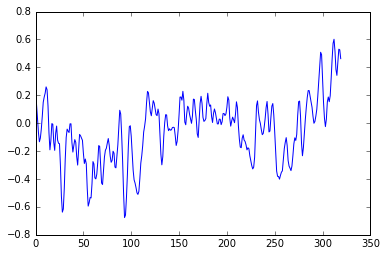

In [64]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [65]:
class CWRNNNumpy:
    
    def __init__(self, out_dim, nb_group, nb_member, bptt_truncate=4):
        # Assign instance variables
        self.out_dim = out_dim
        self.nb_group = nb_group
        self.nb_member = nb_member
        self.hidden_dim = nb_group*nb_member
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.V = np.random.normal(0, 0.1, (out_dim, self.hidden_dim))
        self.W = np.zeros((self.hidden_dim, self.hidden_dim))
        for i in range(nb_group) :
            for j in range(nb_member):
                self.W[i*nb_member+j][i:] = np.random.normal(0, 0.1, (self.hidden_dim-i))



In [66]:
def which_active(self, t):
    active = self.nb_group
    while(True):
        t = t% 2**(active - 1)
        if(t == 0): break;
        active-=1
    return active
CWRNNNumpy.which_active=which_active


def forward_propagation(self, size, initialState):
    # The total number of time steps
    T = size
    # During forward propagation we save all hidden states in s because need them later.
    s = np.zeros((T , self.hidden_dim))
    s[-1] = np.ones( self.hidden_dim)*initialState
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.out_dim))
    # For each time step...
    for t in np.arange(T):
        #active : last group active for time t
        active = self.which_active(t)
        if(active != self.nb_group):
            Wtmp = np.vstack((self.W[:active*self.nb_member],
                              np.zeros((self.hidden_dim-(active*self.nb_member),
                                        self.hidden_dim))))
        else : Wtmp = self.W                      
        s[t] = np.tanh(Wtmp.dot(s[t-1]))
        o[t] = self.V.dot(s[t])
    return [o, s]

CWRNNNumpy.forward_propagation = forward_propagation

In [67]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(len(x), x[0])
    return o

CWRNNNumpy.predict = predict

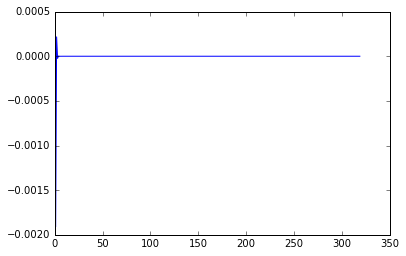

In [81]:
model = CWRNNNumpy(out_dim=1, nb_group=10, nb_member=1)
X_train = data[4][:,0]
X_train = np.ones(320)
o = model.predict(X_train)
plot(o)

In [82]:
def calculate_loss(self, x):
    o, s = self.forward_propagation(len(x), x[1])
    o=o.reshape(x.shape)
    return ((x-o)*(x-o)).sum()
CWRNNNumpy.calculate_loss=calculate_loss

In [83]:
loss = model.calculate_loss( X_train)
loss

320.00629281056047

In [99]:
def bptt(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = (y.reshape((T,1)) - o)**2
    #delta_o[np.arange(len(x)), x] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        active=self.which_active(T-1)
        dLdV += delta_o[t] * np.hstack((s[t][:active*self.nb_member], np.zeros((
                            self.hidden_dim-active*self.nb_member))))
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t])
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            active=self.which_active(T-1)
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            
            dLdW += np.outer(delta_t, np.hstack((s[bptt_step-1][:active*self.nb_member], np.zeros((
                            self.hidden_dim-active*self.nb_member)))))              
            # Update delta for next step
            
            if(active != self.nb_group):
                Wtmp = np.vstack((self.W[:active*self.nb_member],
                                  np.zeros((self.hidden_dim-(active*self.nb_member),
                                            self.hidden_dim))))
            else : Wtmp = self.W   
            delta_t = Wtmp.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdV, dLdW]

CWRNNNumpy.bptt = bptt

In [51]:
def bptt(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = np.zeros(T)
    delta  = np.zeros((T,self.hidden_dim))
    # For each output backwards...
    delta_o[T-1] = (y[T-1]-o[T-1])
    active=self.which_active(T-1)
    if(active != self.nb_group):
        Wtmp = np.vstack((self.W[:active*self.nb_member],
                          np.zeros((self.hidden_dim-(active*self.nb_member),
                                    self.hidden_dim))))
    else : Wtmp = self.W   
    delta[T-1] = (delta_o[T-1]*Wtmp).sum(1) *(1- np.tanh(s[T-1])**2)
    dLdV += delta_o[T-1]*s[T-1]
    #TODO opti ?
    dLdW += delta[T-1]*s[T-2]
    for t in np.arange(T-1)[::-1]:
        #dLdV += np.outer(delta_o[t], s[t].T)
        delta_o[t] = (y[t]-o[t])
        active=self.which_active(T-1)
        if(active != self.nb_group):
            Wtmp = np.vstack((self.W[:active*self.nb_member],
                              np.zeros((self.hidden_dim-(active*self.nb_member),
                                        self.hidden_dim))))
        else : Wtmp = self.W   
        delta[t] = (Wtmp.dot(delta[t+1]) + self.V.dot(delta_o[t]))*(1- np.tanh(s[t])**2)
        dLdV += delta_o[t]*s[t]
        if(t>0):
            dLdW += delta[t]*s[t-1]
    return [dLdV, dLdW]

CWRNNNumpy.bptt = bptt

In [85]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, learning_rate):
    # Calculate the gradients
    dLdV, dLdW = self.bptt(x)
    # Change parameters according to gradients and learning rate
    self.V += learning_rate * dLdV
    self.W += learning_rate * dLdW

CWRNNNumpy.sgd_step = numpy_sdg_step

In [86]:
# Outer SGD Loop
# - model: The RNN model instance
# - x: séquence to generate
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, x, learning_rate=0.0003, nepoch=100):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        # One SGD step
        loss = model.calculate_loss(x)
        losses.append(loss)
        model.sgd_step(x, learning_rate)
        
    return losses
 

In [100]:
losses = train_with_sgd(model, X_train, nepoch=1000, learning_rate=0.0001)

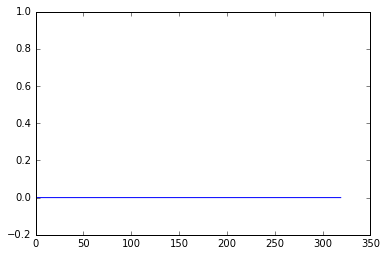

In [101]:

o = model.predict(X_train)
plot(o)
plot(X_train)

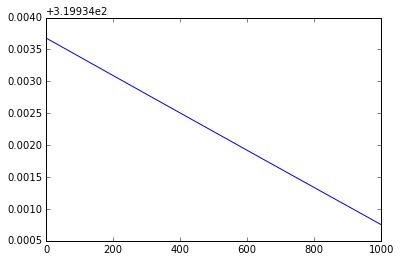

In [102]:
plot(losses)

In [103]:
model.W

array([[ -1.14005293e-01,   1.35976373e-01,   4.44608001e-02,
          2.33213124e-02,  -2.74184286e-03,   5.19874996e-02,
          8.23922951e-03,  -1.85299237e-01,   7.42146894e-02,
          2.43131953e-04],
       [  1.76949694e-03,  -2.42837447e-03,   5.67640151e-02,
         -9.57175913e-02,  -2.23749135e-02,  -1.94640351e-02,
         -6.98136235e-02,   2.29777173e-01,  -5.77844062e-04,
          4.70970671e-02],
       [  1.42990173e-03,   1.26051304e-03,  -4.19316332e-02,
          1.70720734e-02,   1.24909319e-02,   4.83467825e-02,
         -2.28876288e-03,   1.18858350e-01,   1.64776225e-01,
         -1.65128962e-02],
       [  3.37949226e-03,   3.17522678e-03,   7.74589044e-03,
         -4.32448896e-02,  -4.29885818e-02,  -7.76497341e-02,
         -8.93061821e-02,   2.33808847e-01,   1.61407600e-02,
         -3.23936741e-02],
       [  1.17572401e-03,   1.11583015e-03,   2.72253167e-03,
         -2.96723285e-04,   1.94514234e-02,  -1.42919513e-02,
          7.80463983e-02